In [107]:
# Data handling modules
import pandas as pd
import numpy as np
import geopandas as gpd 

# Statistic modules
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Cluster modules
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Plotting and mapping modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")

# Custom functions for array to raster and raster to vector operations
from process_functions import *

In [108]:
df=pd.read_csv('C:/Users/Sarah/OneDrive - Kansas State University/Desktop/scripts_jp/agroecology_paper/data_processing/final_processing/final_post_patrignani_adjustments/variables.csv',index_col=0)

In [109]:
# CV 
(df.std()/df.mean())*100

paws_050      16.721584
om_kg_sq_m    31.835723
pet           10.695086
precip        27.115648
temp           7.499791
depth_adj     40.583938
dtype: float64

In [80]:
df.describe()

,paws_050,om_kg_sq_m,pet,precip,temp,depth_adj
count,316210.000000,316207.000000,319590.000000,317317.000000,317317.000000,316521.000000
mean,8.714345,20.246174,1282.599201,743.051388,12.641791,95.087750
std,1.457177,6.445516,137.175086,201.483201,0.948108,38.590354
min,1.000000,1.000000,0.000352,428.992035,10.540001,0.011830
25%,8.000000,17.000000,1196.598999,561.004028,11.890000,66.255272
50%,9.000000,20.000000,1277.525940,720.937012,12.730000,81.000000
75%,10.000000,24.000000,1380.154785,911.958069,13.330001,150.000000
max,22.000000,225.000000,1590.157471,1207.072998,14.960001,150.000000


In [81]:
# Obtain Index for non_null values 
null_idx= df[df.isnull().any(axis=1)].index
non_null_idx = df[~df.isnull().any(axis=1)].index

df.iloc[non_null_idx].head(3)

,paws_050,om_kg_sq_m,pet,precip,temp,depth_adj
897,11.0,15.0,1294.424194,461.921021,10.650001,35.645321
898,10.0,12.0,1294.222290,461.592010,10.670000,47.127869
899,8.0,13.0,1293.861450,461.333008,10.700001,59.862305


**Climate Variables**

In [82]:
X = df.loc[non_null_idx] # only use non nan values. The irregular bounds of Kansas have nan values. 

climate_features = X [['precip', 'temp', 'pet']] # Select Variables 

# Normalize the values with scaling
scaler= StandardScaler()
X_climate= scaler.fit_transform(climate_features)

# Transform to PCAs capturing 95% of variability 
print('Climate shape', X_climate.shape)
X_climate=PCA(.95).fit_transform(X_climate)
print('Climate PCA fit shape', X_climate.shape)

Climate shape (316183, 3)
Climate PCA fit shape (316183, 2)


**K-means for Climate Variables**

In [83]:
# Kmeans loop to evaluate performance of various cluster numbers for a macro climate cluster
print ('Performance of Kmeans models with Climate Data')
range_n_clusters = [2, 3, 4, 5]

X = X_climate

for n_clusters in range_n_clusters:
    clusters = KMeans(n_clusters)            
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels, metric='sqeuclidean')
    CHS_avg = calinski_harabasz_score(X, cluster_labels)
    print("For", n_clusters, "clusters",
          "silhouette score is:", round(silhouette_avg,2),
          "and the calinski harabasz score is:", round(CHS_avg,2))

Performance of Kmeans models with Climate Data
For 2 clusters silhouette score is: 0.58 and the calinski harabasz score is: 256429.96
For 3 clusters silhouette score is: 0.59 and the calinski harabasz score is: 279490.98
For 4 clusters silhouette score is: 0.56 and the calinski harabasz score is: 284192.49
For 5 clusters silhouette score is: 0.53 and the calinski harabasz score is: 275110.19


In [84]:
# Cluster of 3 has the best performance. Predict this cluster number and append to the original data frame
clusters = KMeans(n_clusters=3, random_state= 2)            
kmean_3_cluster = clusters.fit_predict(X_climate)

df.loc[non_null_idx,'macro'] = kmean_3_cluster + 1 # 1 is added so that the first cluster is 1 instead of 0 
df.iloc[3000:3005].head(3)

,paws_050,om_kg_sq_m,pet,precip,temp,depth_adj,macro
3000,11.0,19.0,1195.774780,633.863037,11.140000,67.773460,1.0
3001,11.0,19.0,1194.763916,633.270020,11.150001,71.147346,1.0
3002,11.0,19.0,1193.629883,632.710022,11.170000,76.029991,1.0


In [85]:
# Get the Stats per each Macro area
# To match macro Organic Matter: 1=19, 2=23, 3= 16
df.groupby(['macro']).mean()

,paws_050,om_kg_sq_m,pet,precip,temp,depth_adj
macro,,,,,,
1.0,9.722304,19.103713,1285.717950,582.816173,11.572326,89.912919
2.0,8.247444,23.860031,1192.945244,948.245008,13.070026,90.120464
3.0,8.275964,16.241680,1421.040594,622.572840,13.220220,108.009816


In [86]:
(df.groupby(['macro']).std()/df.groupby(['macro']).mean())*100

,paws_050,om_kg_sq_m,pet,precip,temp,depth_adj
macro,,,,,,
1.0,9.872262,21.960463,5.846751,16.670294,4.219748,47.415428
2.0,13.177184,26.635625,7.593405,11.095653,5.311341,33.862374
3.0,21.579960,35.190977,4.380201,18.895207,4.504474,38.188656


**Soil Variables**

In [87]:
X = df.loc[non_null_idx]
soil_features = X[['paws_050', 'om_kg_sq_m',  'depth_adj']] # Select Variables  #,

# Normalize the values with scaling
scaler= StandardScaler()
X_soil= scaler.fit_transform(soil_features)

# *Note. Soil data is not transformed into PCAs as 95% captures all compontents
print('Soil data shape', X_soil.shape)

Soil data shape (316183, 3)


**Nested clustering. For each climate macro cluster, cluster a micro cluster on with soil data**

In [88]:
# Divide the data into the three sets of macro clusters by index 
cluster_numbers = list(np.unique(kmean_3_cluster))

nest = []
for i in cluster_numbers:
    idx = np.where(kmean_3_cluster == i)
    nest_cluster = X_soil[idx]              # this is the soil data
    nest.append(nest_cluster)
    
# Check is the length of the list is equivalent to the number of clusters
len(nest)

3

**K-means for Soil Variables for each Macro Cluster**

In [89]:
print ('Performance of Kmeans micro models with soil data')
range_n_clusters = [ 2, 3]

for i in cluster_numbers:
    print ('')
    x = nest[i]
    for n_clusters in range_n_clusters:
        clusters = KMeans(n_clusters)            
        cluster_labels = clusters.fit_predict(x)
        silhouette_avg_s = silhouette_score(x, cluster_labels, metric='sqeuclidean')
        CHS_avg = calinski_harabasz_score(x, cluster_labels)
        print("For", i, 'macro cluster and', n_clusters, "micro clusters",
              "sqeuclidean silhouette score is:", round(silhouette_avg_s,2), 
              "and the calinski harabasz score is:", round(CHS_avg,2))

Performance of Kmeans micro models with soil data

For 0 macro cluster and 2 micro clusters sqeuclidean silhouette score is: 0.7 and the calinski harabasz score is: 106623.8
For 0 macro cluster and 3 micro clusters sqeuclidean silhouette score is: 0.63 and the calinski harabasz score is: 92153.39

For 1 macro cluster and 2 micro clusters sqeuclidean silhouette score is: 0.47 and the calinski harabasz score is: 71487.62
For 1 macro cluster and 3 micro clusters sqeuclidean silhouette score is: 0.46 and the calinski harabasz score is: 65009.35

For 2 macro cluster and 2 micro clusters sqeuclidean silhouette score is: 0.6 and the calinski harabasz score is: 75520.49
For 2 macro cluster and 3 micro clusters sqeuclidean silhouette score is: 0.6 and the calinski harabasz score is: 79859.42


In [90]:
# Predict each micro_cluster with each cluster based on performance metrics 
x = nest[0]
cluster_number = 2
clusters = KMeans(cluster_number,  random_state= 3)            
cluster_1_micro = clusters.fit_predict(x)

x = nest[1]
cluster_number = 2
clusters = KMeans(cluster_number,  random_state= 2)            
cluster_2_micro = clusters.fit_predict(x)

x = nest[2]
cluster_number = 2
clusters = KMeans(cluster_number,  random_state= 2)            
cluster_3_micro = clusters.fit_predict(x)

In [91]:
# Add micro cluster column to each macro cluster 
df.loc[df.loc[df['macro'] == 1].index, 'micro'] = cluster_1_micro + 1 # Macro Cluster 1
df.loc[df.loc[df['macro'] == 2].index, 'micro'] = cluster_2_micro + 1 # Macro Cluster 2
df.loc[df.loc[df['macro'] == 3].index, 'micro'] = cluster_3_micro + 1 # Macro Cluster 3

**Export the Clusters to a Raster and Vector Format**

In [92]:
# Add a single column that provides information for macro and micro cluster.
df['cluster'] = (df.macro*10)+ df.micro

In [93]:
df.iloc[non_null_idx].groupby(['cluster']).mean()

,paws_050,om_kg_sq_m,pet,precip,temp,depth_adj,macro,micro
cluster,,,,,,,,
11.0,9.614512,18.953724,1262.642540,620.906562,11.682305,62.943752,1.0,1.0
12.0,9.958058,19.431759,1336.187001,499.507326,11.331786,148.898146,1.0,2.0
21.0,8.831948,28.694306,1192.519096,951.515356,13.120562,103.039136,2.0,1.0
22.0,7.711116,19.424206,1193.336268,945.244208,13.023655,78.266571,2.0,2.0
31.0,9.391915,19.417830,1414.170884,615.960984,13.126810,98.491022,3.0,1.0
32.0,6.296784,10.608660,1433.224279,634.299212,13.385887,124.891750,3.0,2.0


In [94]:
(df.groupby(['cluster']).std()/df.groupby(['cluster']).mean())*100

,paws_050,om_kg_sq_m,pet,precip,temp,depth_adj,macro,micro
cluster,,,,,,,,
11.0,10.763952,21.744340,5.589841,14.276150,4.046873,28.024144,0.0,0.0
12.0,7.190255,22.306480,4.366104,10.567663,3.814574,4.359015,0.0,0.0
21.0,9.378261,17.052270,7.493266,11.389383,4.803077,31.196283,0.0,0.0
22.0,13.188216,19.509560,7.683928,10.805614,5.721243,29.802337,0.0,0.0
31.0,9.259360,20.477945,4.242405,18.525167,4.720531,39.454368,0.0,0.0
32.0,18.652144,33.910475,4.483978,19.356214,3.806731,31.978069,0.0,0.0


In [95]:
df.to_csv('features_clusters.csv')

In [96]:
# Use one map as the template to reshape array. 
# PRISM Elevation is a standard 800m grid product
template = rasterio.open('C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/elv_wgs84_ks.tif').read(1)
print(template.shape)
new_width = template.shape[1]
new_height = template.shape[0]

(362, 896)


In [97]:
# Conver to array as input to raster file 
cluster = df.cluster.to_numpy() 
#cluster = df
np.nan_to_num(cluster, nan=-9999)
cluster= np.reshape(cluster, template.shape)

In [98]:
# Convert array to raster tif
rasterfn='C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/elv_wgs84_ks.tif'
file_str = 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/cluster.tif'
array2raster(file_str,rasterfn,cluster)    

In [99]:
# Convert tif to vector shape 
path = 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/cluster.tif'
string = 'cluster'
rast2vec(path, string)

**Visualize the Clusters**

In [100]:
# Load the vector file 
shp_path = 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/ks_agro_climate/cluster.shp'
df_map = gpd.read_file(shp_path)

In [101]:
# Divide Clusters for Macro Cluster as whole number and Micro Cluster as decimal 
df_map.cluster = df_map.cluster/10
df_map['cluster'].replace(0, np.NaN, inplace=True) #convert 0 back to nan values

In [102]:
# Shape file of State of Kansas
fp= 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/cb_2018_us_state_500k.shp' # state shape file. 
kansas = gpd.read_file(fp)
ks_map = kansas.NAME.isin(['Kansas']) 
ks_map = kansas[ks_map].loc[0:]
ks_map.to_crs(epsg=4269, inplace=True)

# County shape file, use for county lines
fp= 'C:/Users/Sarah/OneDrive - Kansas State University/Desktop/code/us_county/US_County_Boundaries.shp' # county file

map_county = gpd.read_file(fp)
# Delete Non-contingous US counties 
ks_county = map_county.STATE.isin(['Kansas'])  
map_county = map_county[ks_county].loc[0:]
map_county.to_crs(epsg=4269, inplace=True)

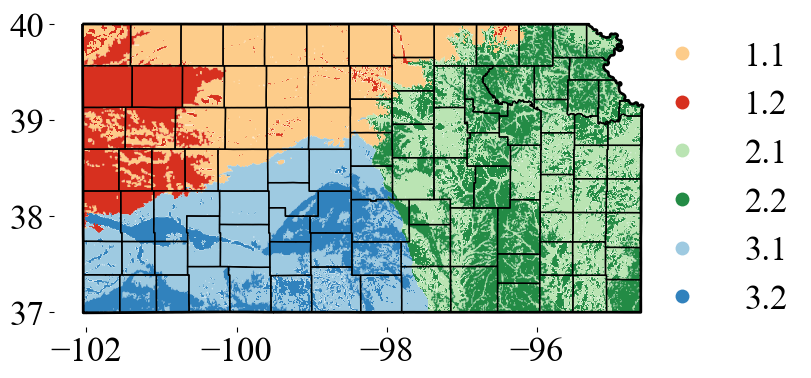

In [103]:
plt.figure(figsize=(8,10), constrained_layout=True) 
ax = plt.axes() #
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 25
 
#plt.title('Kansas Agro-Climatic Zones w/ PAWC, Depth, Organic Matter', fontsize=16)

cmap = mpl.colors.ListedColormap(['#fdcc8a', '#d7301f',
                                   '#bae4b3', "#238b45",
                                    #   '#fef0d9',
                                   '#9ecae1', '#3182bd',
                                   # '#eff3ff','#bdd7e7','#6baed6','#2171b5'
                                  #   '#eff3ff','#bdd7e7','#3182bd','#08519c'
                                   ])#'#bdd7e7'

plot=df_map.plot(column='cluster', cmap=cmap, categorical=True,legend=True, ax=ax, legend_kwds=dict(bbox_to_anchor=(1.24,1), frameon=False))

ks_map.plot(ax=ax, color='none', edgecolor='black', linewidths =2)
map_county.plot(ax=ax, color='none', edgecolor='black', linewidths =1)

plt.box(False)

#plt.savefig('state_map_23.png', bbox_inches = 'tight', dpi=500)

plt.show()